Data normalization is necessary when visualizing data for several key reasons, and I believe the most important reason is for scale uniformity. Different data variables can have vastly different scales and units. For example, grain yield might be in Mg/ha, while nutrient contents might typically range from %. Normalizing these data to a common scale (like 0 to 1) allows them to be compared and visualized on the same axis without one overshadowing the other due to its scale.

Additionally, normalization enhances visualization interpretability. Normalized data aids in creating more interpretable and meaningful visualizations. It ensures that the graphical representations are not misleading due to the differing scales of data attributes, which is crucial for accurately understanding the relationships and patterns in the data. It facilitates fair comparison. When plotting different variables together, normalization allows for a fair comparison by adjusting the data ranges to be equivalent. This is particularly important in plots such as scatter plots, line graphs, and when calculating correlation.

Normalization can also reduce the impact of outliers in the data by bringing all values into a narrow range. This makes the visualization less prone to skewing by extreme values, making trends and patterns clearer. Overall, normalization ensures that visualizations are both visually appealing and analytically accurate, making it easier to derive insights from the data.

Today I'll demonstrate how normalization helps us easily interpret data.

Let's import one dataset.

In [23]:
library(readr)
github="https://raw.githubusercontent.com/agronomy4future/raw_data_practice/main/biomass_N_P.csv"
df= data.frame(read_csv(url(github), show_col_types=FALSE))

head(df, 5)

,season,cultivar,treatment,rep,biomass,nitrogen,phosphorus
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022,cv1,N0,1,9.16,1.23,0.41
2,2022,cv1,N0,2,13.06,1.49,0.45
3,2022,cv1,N0,3,8.40,1.18,0.31
4,2022,cv1,N0,4,11.97,1.42,0.48
5,2022,cv1,N1,1,24.90,1.77,0.49


Let's say this data represents the canopy biomass of a crop along with the concentrations of nitrogen and phosphorus in the canopy in response to different nitrogen levels (N0 to N4). With this data, I'll create a regression graph between biomass and either nitrogen or phosphorus. I'll be using the mean data by cultivar and treatment, so the first step is to summarize the data.

In [24]:
library(dplyr)
summary = data.frame(df %>%
                   group_by(cultivar, treatment) %>%
                   dplyr::summarize(across(c(biomass, nitrogen, phosphorus),
                      .fns= list(Mean=~mean(., na.rm= TRUE),
                       se=~sd(.,na.rm= TRUE) / sqrt(length(.))))))
head(summary, 5)

`summarise()` has grouped output by 'cultivar'. You can override using the
`.groups` argument.


,cultivar,treatment,biomass_Mean,biomass_se,nitrogen_Mean,nitrogen_se,phosphorus_Mean,phosphorus_se
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cv1,N0,10.6475,1.111796,1.3300,0.07427427,0.4125,0.03705289
2,cv1,N1,25.3550,1.232541,1.7775,0.02495830,0.4475,0.01701715
3,cv1,N2,34.4550,3.174625,1.9725,0.05452446,0.4050,0.02217356
4,cv1,N3,40.3550,2.887711,2.0475,0.04049177,0.4075,0.03300884
5,cv1,N4,49.4225,1.478566,2.2475,0.04110454,0.3650,0.04663690


and I'll create the regression graph.

Warning message:
“`position_dodge()` requires non-overlapping x intervals”


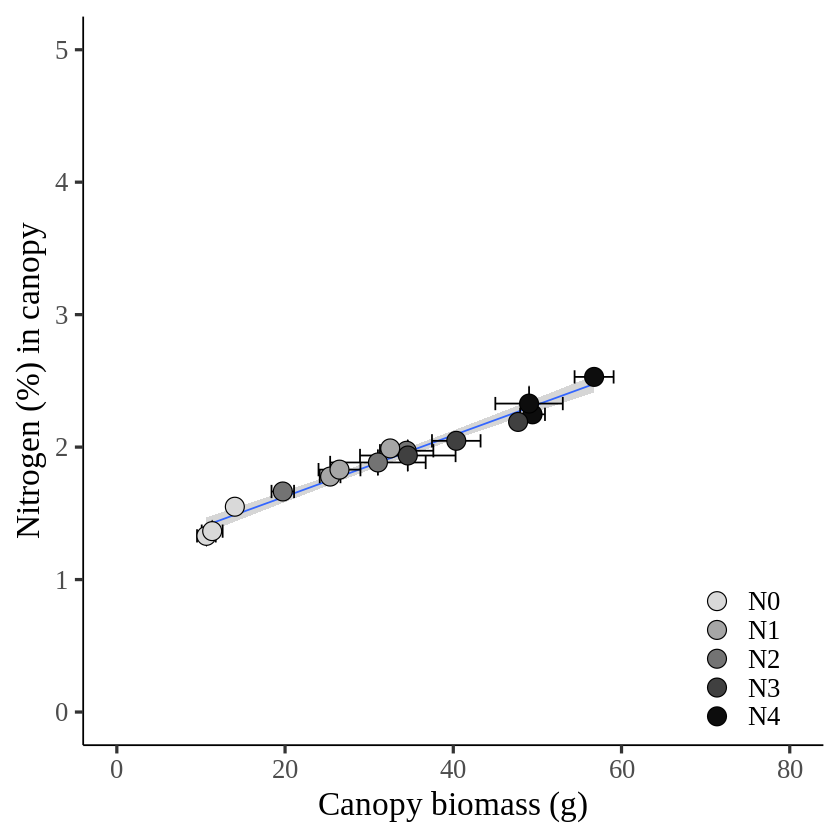

In [25]:
library(ggplot2)
ggplot(data=summary, aes(x=biomass_Mean, y=nitrogen_Mean))+
  geom_smooth(method='lm', linetype=1, se=TRUE, formula=y~x, linewidth=0.5)+
  geom_errorbar(aes(xmin=biomass_Mean-biomass_se,
                    xmax=biomass_Mean+biomass_se),
                    position=position_dodge(0.9), width=0.1) +
  geom_errorbar(aes(ymin=nitrogen_Mean-nitrogen_se,
                    ymax=nitrogen_Mean+nitrogen_se),
                    position=position_dodge(0.9), width=0.1) +
  geom_point(aes(fill=treatment, shape=treatment), color="black", size=5)+
  scale_fill_manual(values=c("grey85","grey65","grey45","grey25","grey5"))+
  scale_shape_manual(values=rep(c(21),5))+
  scale_x_continuous(breaks=seq(0,80,20), limits=c(0,80))+
  scale_y_continuous(breaks=seq(0,5,1), limits=c(0,5))+
  labs(x="Canopy biomass (g)", y="Nitrogen (%) in canopy") +
  theme_classic(base_size=20, base_family="serif")+
  theme(legend.position=c(0.89,0.13),
        legend.title=element_blank(),
        legend.key=element_rect(color=alpha("white",.001),
                   fill=alpha("white",.001)),
        legend.background=element_rect(fill=alpha("white",.001)),
        axis.line=element_line(linewidth=0.5, colour="black"))

Warning message:
“`position_dodge()` requires non-overlapping x intervals”


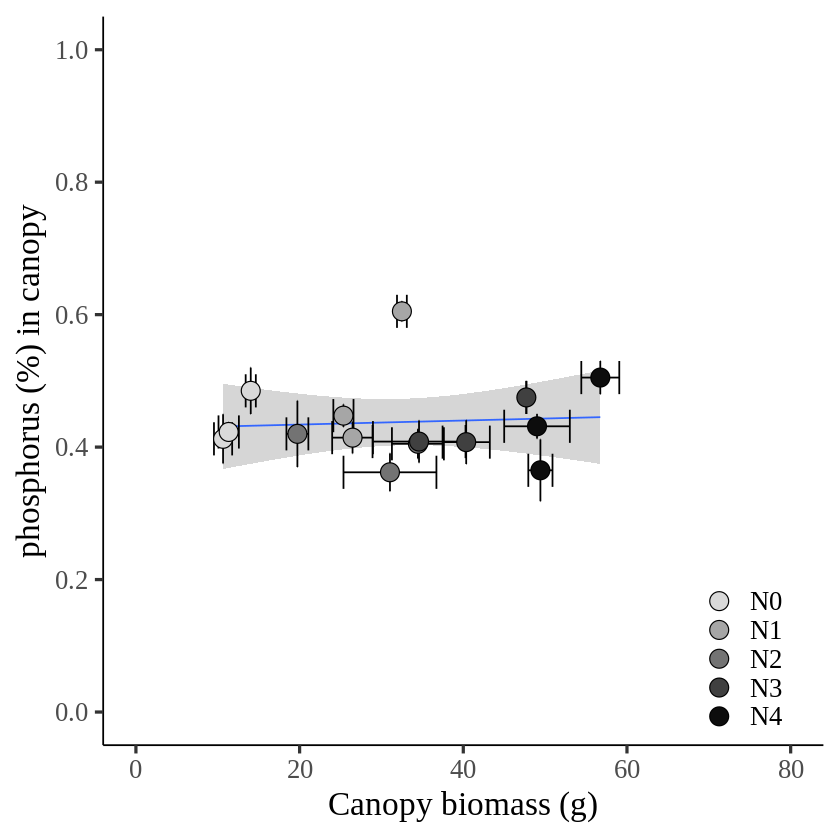

In [27]:
library(ggplot2)
ggplot(data=summary, aes(x=biomass_Mean, y=phosphorus_Mean))+
  geom_smooth(method='lm', linetype=1, se=TRUE, formula=y~x, linewidth=0.5)+
  geom_errorbar(aes(xmin=biomass_Mean-biomass_se,
                    xmax=biomass_Mean+biomass_se),
                    position=position_dodge(0.9), width=0.05) +
  geom_errorbar(aes(ymin=phosphorus_Mean-phosphorus_se,
                    ymax=phosphorus_Mean+phosphorus_se),
                    position=position_dodge(0.9), width=0.05) +
  geom_point(aes(fill=treatment, shape=treatment), color="black", size=5)+
  scale_fill_manual(values=c("grey85","grey65","grey45","grey25","grey5"))+
  scale_shape_manual(values=rep(c(21),5))+
  scale_x_continuous(breaks=seq(0,80,20), limits=c(0,80))+
  scale_y_continuous(breaks=seq(0,1,0.2), limits=c(0,1))+
  labs(x="Canopy biomass (g)", y="phosphorus (%) in canopy") +
  theme_classic(base_size=20, base_family="serif")+
  theme(legend.position=c(0.89,0.13),
        legend.title=element_blank(),
        legend.key=element_rect(color=alpha("white",.001),
                                fill=alpha("white",.001)),
        legend.background=element_rect(fill=alpha("white",.001)),
        axis.line=element_line(linewidth=0.5, colour="black"))

I created separate graphs for nitrogen and phosphorus, but sometimes we need to display two graphs using the same unit. So, I'll create one graph using facet_wrap(). To do this, the two variables (nitrogen and phosphorus) should be in the same column, and I'll transpose the column data to row data using pivot_longer()

In [28]:
library(dplyr)
library(tidyr)
df1= data.frame(df %>%
               pivot_longer(
               cols= c(nitrogen, phosphorus),
               names_to= "nutrient",
               values_to= "percentage"))

head(df1, 5)

,season,cultivar,treatment,rep,biomass,nutrient,percentage
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,2022,cv1,N0,1,9.16,nitrogen,1.23
2,2022,cv1,N0,1,9.16,phosphorus,0.41
3,2022,cv1,N0,2,13.06,nitrogen,1.49
4,2022,cv1,N0,2,13.06,phosphorus,0.45
5,2022,cv1,N0,3,8.40,nitrogen,1.18


and, again I'll summarize data.

In [29]:
library(dplyr)
summary = data.frame(df1 %>%
                   group_by(cultivar, treatment, nutrient) %>%
                   dplyr::summarize(across(c(biomass, percentage),
                      .fns= list(Mean=~mean(., na.rm= TRUE),
                       se=~sd(.,na.rm= TRUE) / sqrt(length(.))))))
head(summary, 5)

`summarise()` has grouped output by 'cultivar', 'treatment'. You can override
using the `.groups` argument.


,cultivar,treatment,nutrient,biomass_Mean,biomass_se,percentage_Mean,percentage_se
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,cv1,N0,nitrogen,10.6475,1.111796,1.3300,0.07427427
2,cv1,N0,phosphorus,10.6475,1.111796,0.4125,0.03705289
3,cv1,N1,nitrogen,25.3550,1.232541,1.7775,0.02495830
4,cv1,N1,phosphorus,25.3550,1.232541,0.4475,0.01701715
5,cv1,N2,nitrogen,34.4550,3.174625,1.9725,0.05452446


Please compare the previous summary code. It was slightly changed due to the structure of the data. I'll create a graph again using facet_wrap().

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”


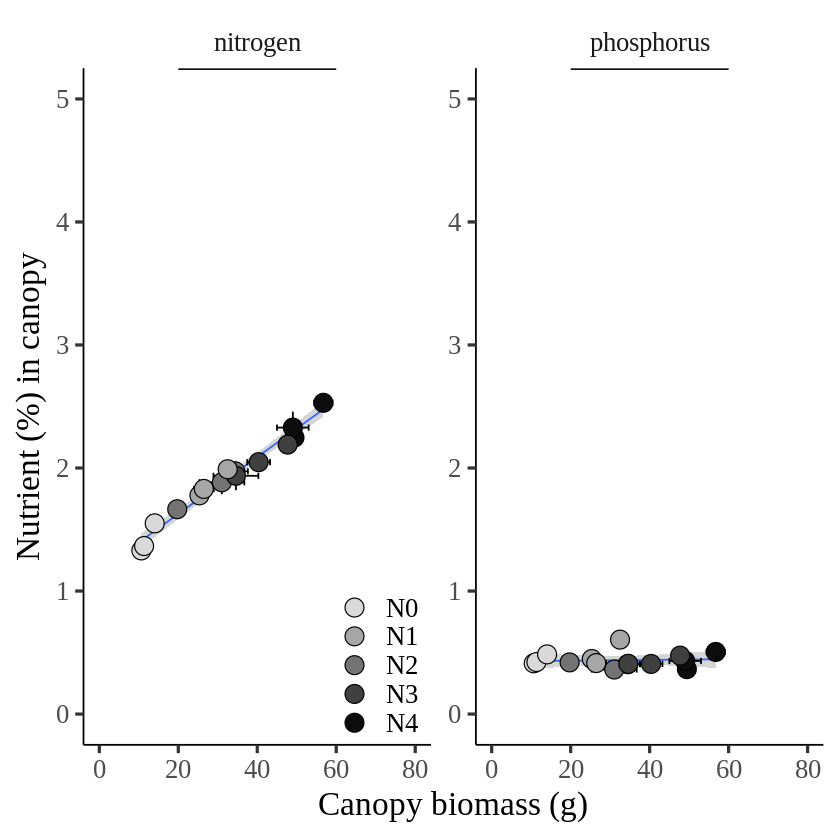

In [30]:
library(ggplot2)
ggplot(data=summary, aes(x=biomass_Mean, y=percentage_Mean))+
  geom_smooth(method='lm', linetype=1, se=TRUE, formula=y~x, linewidth=0.5)+
  geom_errorbar(aes(xmin=biomass_Mean-biomass_se, xmax=biomass_Mean+biomass_se),
                position=position_dodge(0.9), width=0.05) +
  geom_errorbar(aes(ymin=percentage_Mean-percentage_se, ymax=percentage_Mean+percentage_se),
                position=position_dodge(0.9), width=0.05) +
  geom_point(aes(fill=treatment, shape=treatment), color="black", size=5)+
  scale_fill_manual(values=c("grey85","grey65","grey45","grey25","grey5"))+
  scale_shape_manual(values=rep(c(21),5))+
  scale_x_continuous(breaks=seq(0,80,20), limits=c(0,80))+
  scale_y_continuous(breaks=seq(0,5,1), limits=c(0,5))+
  labs(x="Canopy biomass (g)", y="Nutrient (%) in canopy") +
  facet_wrap(~nutrient, scales="free") +
  annotate("segment", x=20, xend=60, y=Inf,yend=Inf, color="black", lwd=1)+
  theme_classic(base_size=20, base_family="serif")+
  theme(legend.position=c(0.40,0.13),
        legend.title=element_blank(),
        legend.key=element_rect(color=alpha("white",.001),
                                fill=alpha("white",.001)),
        legend.background=element_rect(fill=alpha("white",.001)),
        axis.line=element_line(linewidth=0.5, colour="black"),
        strip.background=element_rect(color="white",
                                      linewidth=0.5,linetype="solid"))

If I set up the same unit, it's not easy to see the trend between biomass and phosphorus, as the unit of phosphorus is much smaller than nitrogen. In this case, normalizing the data will solve this problem. In the introduction, I suggested that the benefit of normalization is scale uniformity and improved visualization interpretability. Let's see if this holds true.

Before normalization, it's important to understand the structure of the data. In the df dataset, determining the appropriate grouping for normalization is crucial.

In [12]:
head (df, 5)

,season,cultivar,treatment,rep,biomass,nitrogen,phosphorus
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022,cv1,N0,1,9.16,1.23,0.41
2,2022,cv1,N0,2,13.06,1.49,0.45
3,2022,cv1,N0,3,8.40,1.18,0.31
4,2022,cv1,N0,4,11.97,1.42,0.48
5,2022,cv1,N1,1,24.90,1.77,0.49


I want to see the trend between biomass and either nitrogen or phosphorus across the range of the nitrogen levels at different season, so I'll determine grouping of season and cultivar.

I'll use the below code.

In [31]:
library(dplyr)
Normalized1= data.frame(df %>%
            group_by(season, cultivar) %>%
            dplyr::mutate(
            biomass_n=(biomass-mean(biomass, na.rm=T))/sd(biomass, na.rm=T),
                  nitrogen_n=(nitrogen-mean(nitrogen, na.rm=T))/sd(nitrogen, na.rm=T),
                  phosphorus_n=(phosphorus-mean(phosphorus, na.rm=T))/sd(phosphorus, na.rm=T),)
)

Normalized=Normalized1[,c(-4,-5,-6,-7)]

head(Normalized,5)

,season,cultivar,treatment,biomass_n,nitrogen_n,phosphorus_n
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,2022,cv1,N0,-1.6187589,-1.9459123,0.0388260
2,2022,cv1,N0,-1.3429185,-1.1615136,0.6600419
3,2022,cv1,N0,-1.6725124,-2.0967583,-1.5142138
4,2022,cv1,N0,-1.4200123,-1.3726979,1.1259539
5,2022,cv1,N1,-0.5054952,-0.3167764,1.2812579


Now, all data was normalized. In the code, I used the below calculation to normalize each variable.

In [ ]:
biomass_n=(biomass-mean(biomass))/sd(biomass)
nitrogen_n=(nitrogen-mean(nitrogen))/sd(nitrogen)
phosphorus_n=(phosphorus-mean(phosphorus))/sd(phosphorus)

This is because my calculation is based on Z-test.

Again!! I'll transpose data from column to row to create a graph using facet_wrap().

In [32]:
library(dplyr)
library(tidyr)
df2= data.frame(Normalized %>%
                   pivot_longer(
                   cols= c(nitrogen_n, phosphorus_n),
                   names_to= "nutrient",
                   values_to= "percentage"))

head(df2, 5)

,season,cultivar,treatment,biomass_n,nutrient,percentage
,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,2022,cv1,N0,-1.618759,nitrogen_n,-1.9459123
2,2022,cv1,N0,-1.618759,phosphorus_n,0.0388260
3,2022,cv1,N0,-1.342918,nitrogen_n,-1.1615136
4,2022,cv1,N0,-1.342918,phosphorus_n,0.6600419
5,2022,cv1,N0,-1.672512,nitrogen_n,-2.0967583


and I'll summarize data again.

In [33]:
library(dplyr)
summary2 = data.frame(df2 %>%
                     group_by(cultivar, treatment, nutrient) %>%
                     dplyr::summarize(across(c(biomass_n, percentage),
                              .fns= list(Mean=~mean(., na.rm= TRUE),
                                se=~sd(.,na.rm= TRUE) / sqrt(length(.))))))
head(summary2,5)

`summarise()` has grouped output by 'cultivar', 'treatment'. You can override
using the `.groups` argument.


,cultivar,treatment,nutrient,biomass_n_Mean,biomass_n_se,percentage_Mean,percentage_se
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,cv1,N0,nitrogen_n,-1.5135505,0.07863543,-1.64422051,0.22407940
2,cv1,N0,phosphorus_n,-1.5135505,0.07863543,0.07765199,0.57544614
3,cv1,N1,nitrogen_n,-0.4733139,0.08717557,-0.29414954,0.07529715
4,cv1,N1,phosphorus_n,-0.4733139,0.08717557,0.62121593,0.26428309
5,cv1,N2,nitrogen_n,0.1703138,0.22453584,0.29414954,0.16449584


and create a graph again.

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”


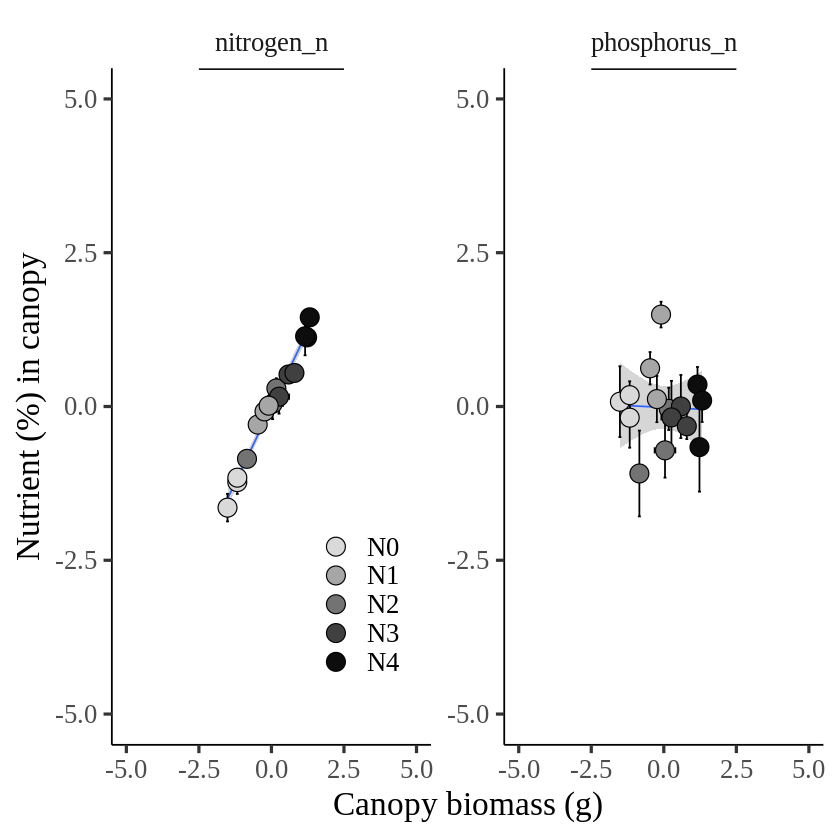

In [34]:
library(ggplot2)
ggplot(data=summary2, aes(x=biomass_n_Mean, y=percentage_Mean))+
  geom_smooth(method='lm', linetype=1, se=TRUE, formula=y~x, linewidth=0.5)+
  geom_errorbar(aes(xmin=biomass_n_Mean-biomass_n_se,
                    xmax=biomass_n_Mean+biomass_n_se),
                    position=position_dodge(0.9), width=0.1) +
  geom_errorbar(aes(ymin=percentage_Mean-percentage_se,
                    ymax=percentage_Mean+percentage_se),
                    position=position_dodge(0.9), width=0.1) +
  geom_point(aes(fill=treatment, shape=treatment), color="black", size=5)+
  scale_fill_manual(values=c("grey85","grey65","grey45","grey25","grey5"))+
  scale_shape_manual(values=rep(c(21),5))+
  scale_x_continuous(breaks=seq(-5,5,2.5), limits=c(-5,5))+
  scale_y_continuous(breaks=seq(-5,5,2.5), limits=c(-5,5))+
  labs(x="Canopy biomass (g)", y="Nutrient (%) in canopy") +
  facet_wrap(~nutrient, scales="free") +
  annotate("segment", x=-2.5, xend=2.5, y=Inf,yend=Inf, color="black", lwd=1) +
  theme_classic(base_size=20, base_family="serif")+
  theme(legend.position=c(0.35,0.22),
        legend.title=element_blank(),
        legend.key=element_rect(color=alpha("white",.001),
                                fill=alpha("white",.001)),
        legend.background=element_rect(fill=alpha("white",.001)),
        axis.line=element_line(linewidth=0.5, colour="black"),
        strip.background=element_rect(color="white",
                                      linewidth=0.5,linetype="solid"))

Now, I can compare two different units of data in the same graph. It's much easier to see the trend between nitrogen and phosphorus. This is the benefit of normalization, such as scale uniformity and improved visualization interpretability.

One more tip!!!

It would be much easier to see the trend in one graph panel. So, I'll combine nitrogen and phosphorus in one graph.

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”


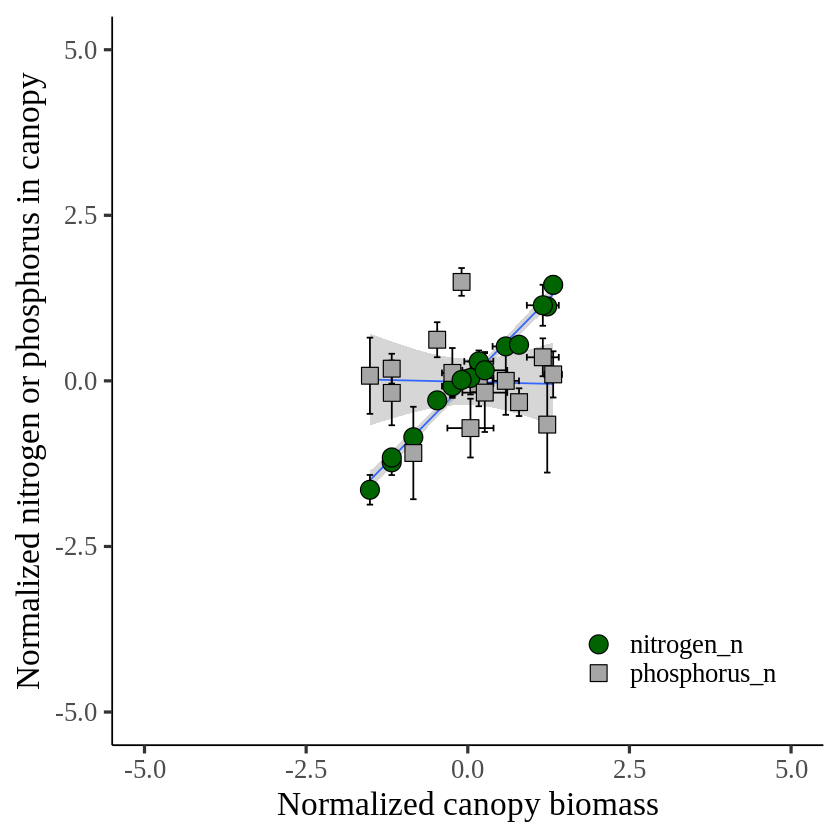

In [35]:
library(ggplot2)
ggplot(data=summary2, aes(x=biomass_n_Mean, y=percentage_Mean))+
  geom_smooth(aes(group=nutrient), method='lm', linetype=1, se=TRUE, formula=y~x, linewidth=0.5)+
  geom_errorbar(aes(xmin=biomass_n_Mean-biomass_n_se,
                    xmax=biomass_n_Mean+biomass_n_se),
                    position=position_dodge(0.9), width=0.1) +
  geom_errorbar(aes(ymin=percentage_Mean-percentage_se,
                    ymax=percentage_Mean+percentage_se),
                    position=position_dodge(0.9), width=0.1) +
  geom_point(aes(fill=nutrient, shape=nutrient), color="black", size=5)+
  scale_fill_manual(values=c("darkgreen","grey65")) +
  scale_shape_manual(values=c(21, 22))+
  scale_x_continuous(breaks=seq(-5,5,2.5), limits=c(-5,5))+
  scale_y_continuous(breaks=seq(-5,5,2.5), limits=c(-5,5))+
  labs(x="Normalized canopy biomass", y="Normalized nitrogen or phosphorus in canopy") +
  theme_classic(base_size=20, base_family="serif")+
  theme(legend.position=c(0.80,0.13),
        legend.title=element_blank(),
        legend.key=element_rect(color=alpha("white",.001),
                                fill=alpha("white",.001)),
        legend.background=element_rect(fill=alpha("white",.001)),
        axis.line=element_line(linewidth=0.5, colour="black"),
        strip.background=element_rect(color="white",
                                      linewidth=0.5, linetype="solid"))

Now, it's much clear to see the trend!!

I'll highlight that all the data is located in the middle of the panel.

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”


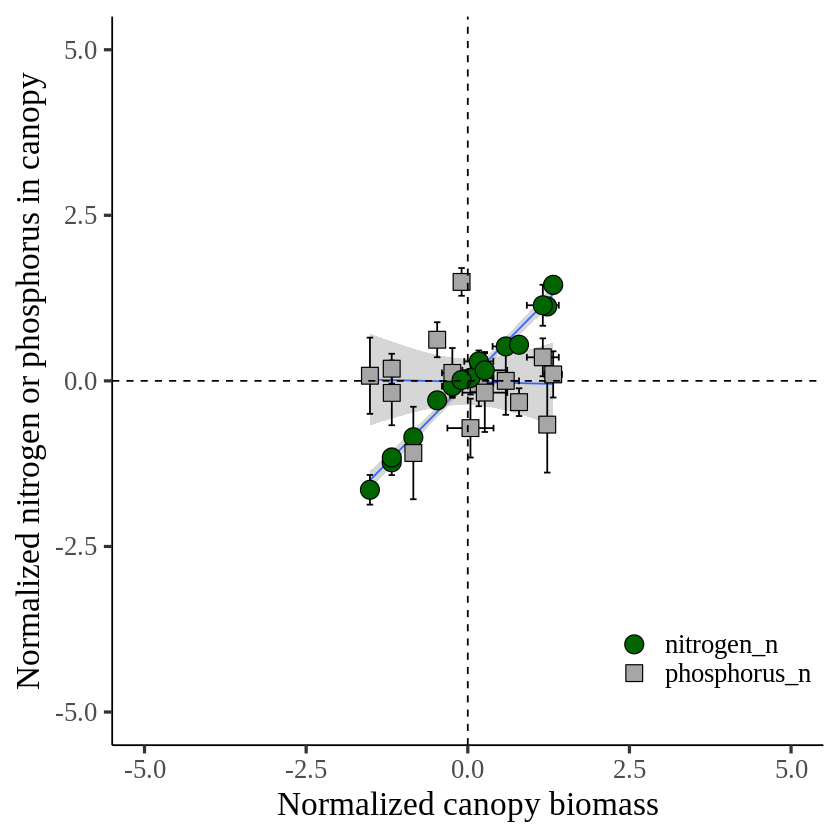

In [36]:
library(ggplot2)
ggplot(data=summary2, aes(x=biomass_n_Mean, y=percentage_Mean))+
  geom_smooth(aes(group=nutrient), method='lm', linetype=1, se=TRUE, formula=y~x, linewidth=0.5)+
  geom_errorbar(aes(xmin=biomass_n_Mean-biomass_n_se, xmax=biomass_n_Mean+biomass_n_se),
                position=position_dodge(0.9), width=0.1) +
  geom_errorbar(aes(ymin=percentage_Mean-percentage_se, ymax=percentage_Mean+percentage_se),
                position=position_dodge(0.9), width=0.1) +
  geom_point(aes(fill=nutrient, shape=nutrient), color="black", size=5)+
  scale_fill_manual(values=c("darkgreen","grey65")) +
  scale_shape_manual(values=c(21, 22))+
  geom_vline(xintercept=0, linetype="dashed", color="black") +
  geom_hline(yintercept=0, linetype="dashed", color="black") +
  scale_x_continuous(breaks=seq(-5,5,2.5), limits=c(-5,5))+
  scale_y_continuous(breaks=seq(-5,5,2.5), limits=c(-5,5))+
  labs(x="Normalized canopy biomass", y="Normalized nitrogen or phosphorus in canopy") +
  theme_classic(base_size=20, base_family="serif")+
  theme(legend.position=c(0.85,0.13),
        legend.title=element_blank(),
        legend.key=element_rect(color=alpha("white",.001),
                                fill=alpha("white",.001)),
        legend.background=element_rect(fill=alpha("white",.001)),
        axis.line=element_line(linewidth=0.5, colour="black"),
        strip.background=element_rect(color="white",
                                      linewidth=0.5,linetype="solid"))